## Categorising countries

### Data Source

The data used in this task was orginally sourced from Help.NGO. This international non-governmental organisation specialises in emergency response, preparedness, and risk mitigation.  

### Dataset Attributes
- country: name of the country
- child_mort: death of children under 5 years of age per 1000 live births
- exports: exports of goods and services per capita. Given as a percentage of the GDP per capita
- health: total health spending per capita. Given as a percentage of GDP per capita
- imports: imports of goods and services per capita. Given as a percentage of the GDP per capita
- income: net income per person
- inflation: the measurement of the annual growth rate of the Total GDP
- life_expec: the average number of years a new born child would live if the current mortality patterns remain the same
- total_fer: the number of children that would be born to each woman if the current age-fertility rates remains the same
- gdpp: the GDP per capita. Calculated as the Total GDP divided by the total population.

## Objective  
To group countries using socio-economic and health factors to determine the development status of the country.

In [59]:
# Import libraries
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

In [60]:
# Random state seed
rseed = 42

## Load and explore data

In [61]:
# Import the dataset
country_df = pd.read_csv('Country-data.csv')

In [62]:
# Check the shape
print("Dataset head:", country_df.head())
print("Dataset shape:", country_df.shape)


Dataset head:                country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  
0       9.44        56.2       5.82    553  
1       4.49        76.3       1.65   4090  
2      16.10        76.5       2.89   4460  
3      22.40        60.1       6.16   3530  
4       1.44        76.8       2.13  12200  
Dataset shape: (167, 10)


In [63]:
# Check datatypes & counts
print(country_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB
None


In [64]:
# Get descriptive statistics
print(country_df.describe())

       child_mort     exports      health     imports         income  \
count  167.000000  167.000000  167.000000  167.000000     167.000000   
mean    38.270060   41.108976    6.815689   46.890215   17144.688623   
std     40.328931   27.412010    2.746837   24.209589   19278.067698   
min      2.600000    0.109000    1.810000    0.065900     609.000000   
25%      8.250000   23.800000    4.920000   30.200000    3355.000000   
50%     19.300000   35.000000    6.320000   43.300000    9960.000000   
75%     62.100000   51.350000    8.600000   58.750000   22800.000000   
max    208.000000  200.000000   17.900000  174.000000  125000.000000   

        inflation  life_expec   total_fer           gdpp  
count  167.000000  167.000000  167.000000     167.000000  
mean     7.781832   70.555689    2.947964   12964.155689  
std     10.570704    8.893172    1.513848   18328.704809  
min     -4.210000   32.100000    1.150000     231.000000  
25%      1.810000   65.300000    1.795000    1330.000000

In [65]:
# Identify any missing data
missing_data = country_df.isnull().sum()
print(missing_data)

country       0
child_mort    0
exports       0
health        0
imports       0
income        0
inflation     0
life_expec    0
total_fer     0
gdpp          0
dtype: int64


## Preprocessing and Feature Selection

In [66]:
# Drop any non-numeric features (columns)

# Keep only numeric columns
country_df_numeric = country_df.select_dtypes(include='number')
print(country_df_numeric.head())

   child_mort  exports  health  imports  income  inflation  life_expec  \
0        90.2     10.0    7.58     44.9    1610       9.44        56.2   
1        16.6     28.0    6.55     48.6    9930       4.49        76.3   
2        27.3     38.4    4.17     31.4   12900      16.10        76.5   
3       119.0     62.3    2.85     42.9    5900      22.40        60.1   
4        10.3     45.5    6.03     58.9   19100       1.44        76.8   

   total_fer   gdpp  
0       5.82    553  
1       1.65   4090  
2       2.89   4460  
3       6.16   3530  
4       2.13  12200  


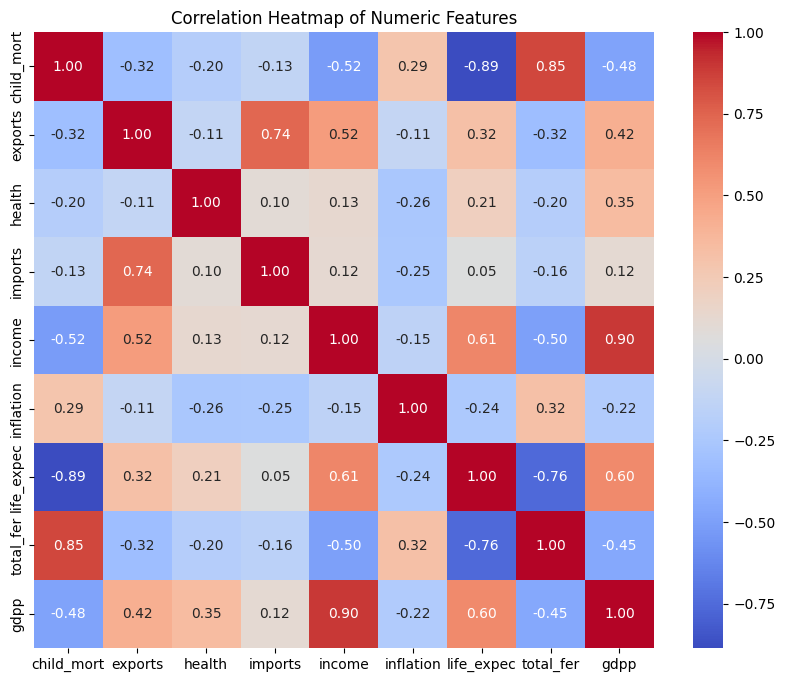

In [67]:
# Create a correlation map of features to explore relationships between features
# Hint: Explore seaborn heatmap
# Calculate the correlation matrix for numeric features
corr_matrix = country_df_numeric.corr()

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

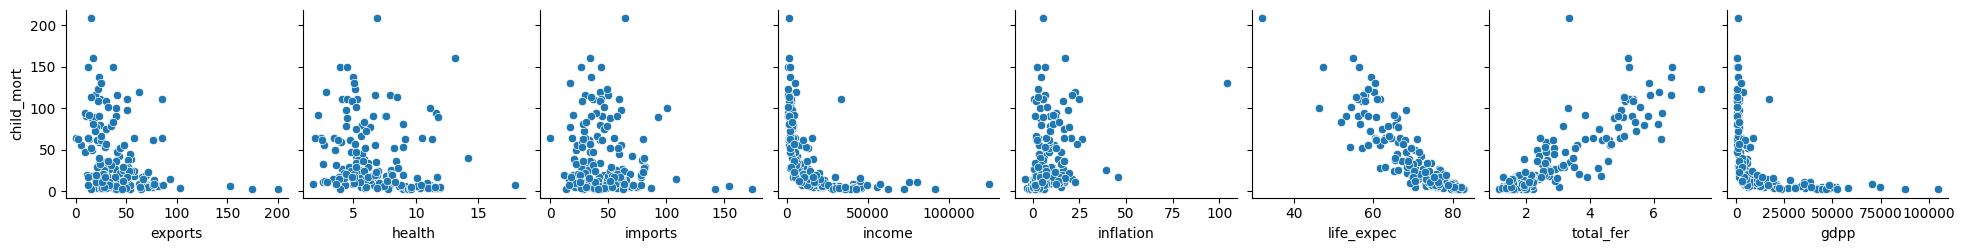

In [68]:
# Explore the continuous independent features against child_mort using scatter plots.
# Define dependent and independent variables
dependent_var = 'child_mort'
independent_vars = [col for col in country_df_numeric.columns if col != dependent_var]

# Use pairplot to create scatter plots for each independent variable against the dependent variable
sns.pairplot(country_df_numeric, x_vars=independent_vars, y_vars=[dependent_var], kind='scatter')
plt.show()

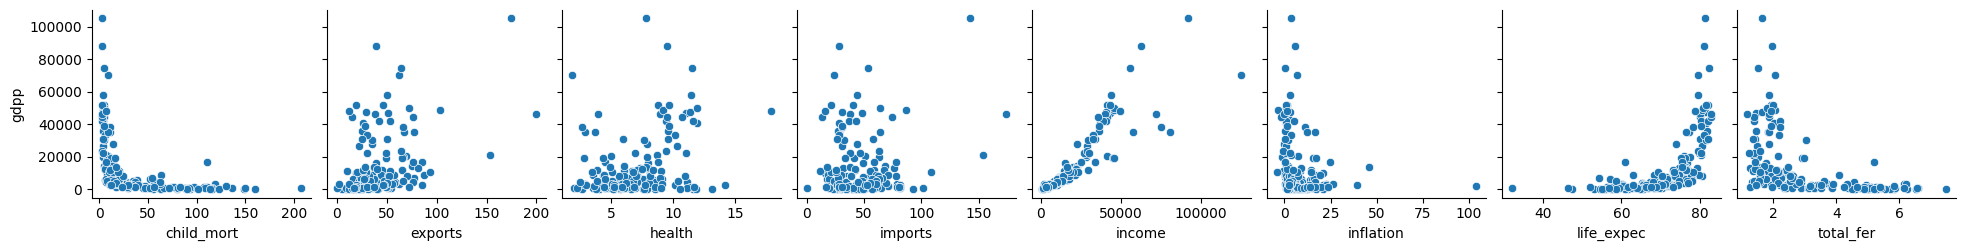

In [69]:
# Explore the continuous independent features against gdpp using scatter plots.
# Define dependent and independent variables
dependent_var = 'gdpp'
independent_vars = [col for col in country_df_numeric.columns if col != dependent_var]

# Use pairplot to create scatter plots for each independent variable against the dependent variable
sns.pairplot(country_df_numeric, x_vars=independent_vars, y_vars=[dependent_var], kind='scatter')
plt.show()

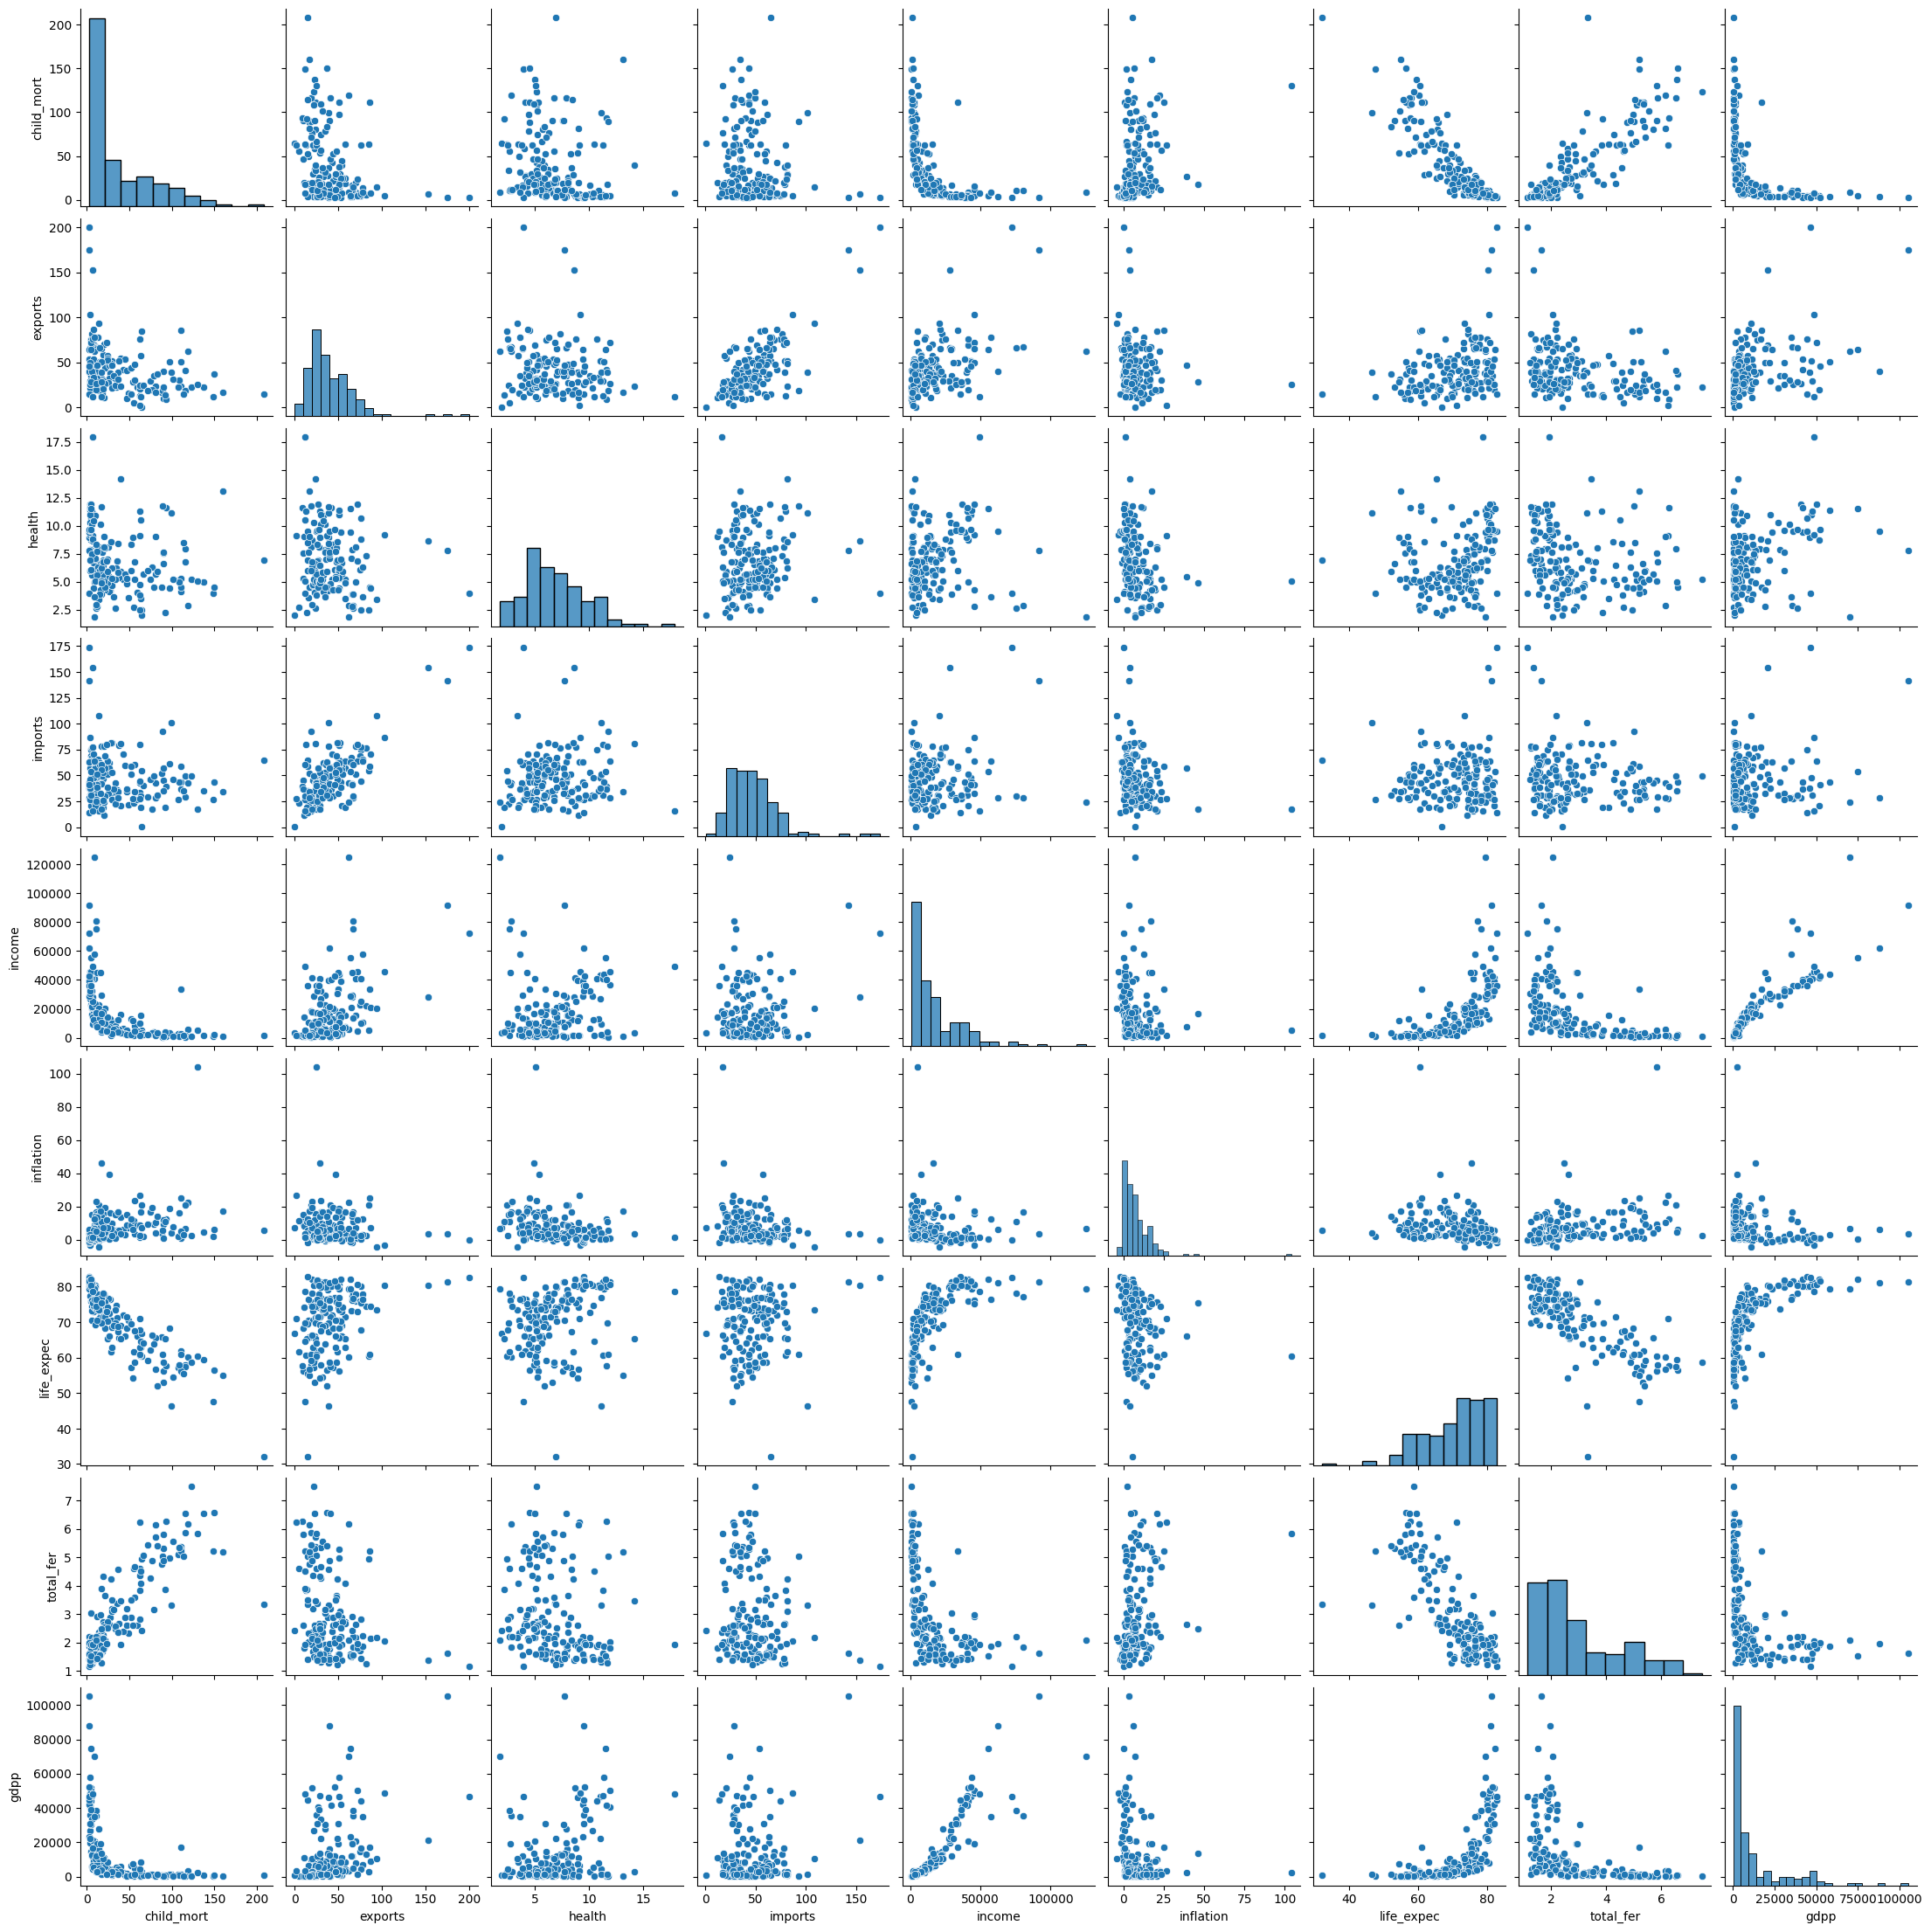

In [70]:
# Create a pair plot
# Hint: Explore seaborn pairplot
# Create a pair plot for the numeric DataFrame
sns.pairplot(country_df_numeric)

# Display the plot
plt.show()

Note the peaks in the diagonal graphs that are distinct from each other or only overlap slightly. Looking at the scatter plot distributions may also give you some indication of features that would be good candidates for clustering the data.

### Scaling the Data

In [71]:
# Normalise the data using MinMaxScaler
# Name the normalised dataframe "df_scaled"

scaler = MinMaxScaler()

# Fit and transform the numeric DataFrame, then convert the output back to a DataFrame
df_scaled = pd.DataFrame(scaler.fit_transform(country_df_numeric), columns=country_df_numeric.columns)
df_scaled.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,0.426485,0.049482,0.358608,0.257765,0.008047,0.126144,0.475345,0.736593,0.003073
1,0.068160,0.139531,0.294593,0.279037,0.074933,0.080399,0.871795,0.078864,0.036833
2,0.120253,0.191559,0.146675,0.180149,0.098809,0.187691,0.875740,0.274448,0.040365
3,0.566699,0.311125,0.064636,0.246266,0.042535,0.245911,0.552268,0.790221,0.031488
4,0.037488,0.227079,0.262275,0.338255,0.148652,0.052213,0.881657,0.154574,0.114242


## K-Means Clustering

### Selecting K

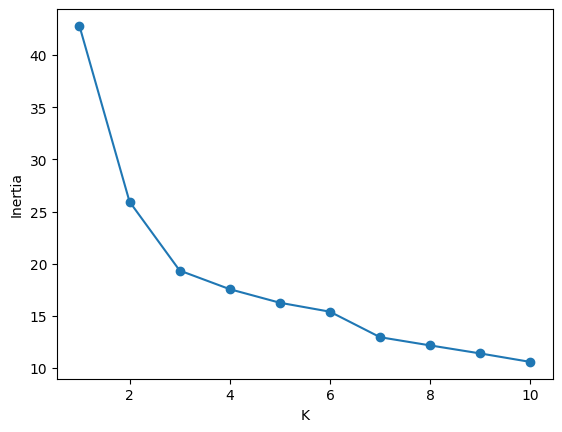

In [72]:
# Plot elbow curve
def eval_Kmeans(x, k, r):
    kmeans = KMeans(n_clusters=k, random_state=r, max_iter=500)
    kmeans.fit(x)
    return kmeans.inertia_

def elbow_Kmeans(x, max_k=10, r=42):
    within_cluster_vars = [eval_Kmeans(x, k, r) for k in range(1, max_k+1)]
    plt.plot(range(1, 11), within_cluster_vars,marker='o')
    plt.xlabel('K')
    plt.ylabel('Inertia')
    plt.show()

# Plot elbow curve using scaled dataset
elbow_Kmeans(df_scaled)

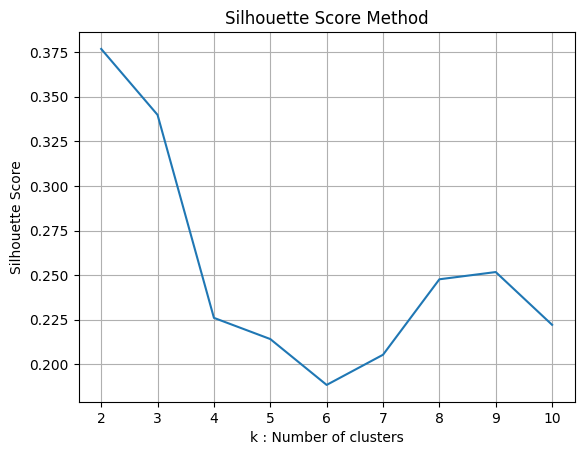

In [73]:
# Silhouette score method
kmax = 10
sil = []
plt.plot()
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=rseed, max_iter=500)
    kmeans.fit(df_scaled)
    labels = kmeans.labels_
    sil.append(silhouette_score(df_scaled, labels, metric='euclidean'))

sns.lineplot(x=range(2, kmax+1), y=sil)
plt.title('Silhouette Score Method')
plt.xlabel('k : Number of clusters')
plt.ylabel("Silhouette Score")
plt.grid(visible=True)
plt.show()

Based on the elbow and silhouette score method choose a value for K.

**Analysis:**

From these plots, K=3 appears to be a strong choice.

- Elbow Curve: decreases rapidly from K=1 to K=3, and then the rate of decrease starts to level off. This suggests that 3 clusters captures a good amount of variance without adding unnecessary complexity.

- Silhouette Score: the score is highest at K=2, but the next-best score is at K=3 and it drops more noticeably beyond K=3. A higher silhouette score indicates better-defined, more coherent clusters.

In practice, K=3 provides a good balance between the elbow method results and a high silhouette score.

## Fitting a K-Means Model with the selected K value

In [74]:
# Remember to set the random_state to rseed
# Set parameters
selected_K = 3
rseed = 42

# Fit the KMeans model on the normalized dataset
kmeans_model = KMeans(n_clusters=selected_K, random_state=rseed, max_iter=500)
kmeans_model.fit(df_scaled)

# Get the cluster labels for each record
cluster_labels = kmeans_model.labels_

In [75]:
# Count the number of records in each cluster
cluster_counts = pd.Series(cluster_labels).value_counts()
print("Number of records in each cluster:")
print(cluster_counts)

Number of records in each cluster:
0    87
2    45
1    35
Name: count, dtype: int64


In [76]:
# Check model performance with the silhouette coefficient
silhouette_avg = silhouette_score(df_scaled, cluster_labels)
print(f"\nSilhouette Coefficient: {silhouette_avg:.3f}")


Silhouette Coefficient: 0.340


## Predictions

In [77]:
# Add the predicted cluster label column to the original dataframe
country_df['cluster'] = cluster_labels

# Display the first few rows of the updated dataframe
print(country_df.head())

               country  child_mort  exports  health  imports  income  \
0          Afghanistan        90.2     10.0    7.58     44.9    1610   
1              Albania        16.6     28.0    6.55     48.6    9930   
2              Algeria        27.3     38.4    4.17     31.4   12900   
3               Angola       119.0     62.3    2.85     42.9    5900   
4  Antigua and Barbuda        10.3     45.5    6.03     58.9   19100   

   inflation  life_expec  total_fer   gdpp  cluster  
0       9.44        56.2       5.82    553        2  
1       4.49        76.3       1.65   4090        0  
2      16.10        76.5       2.89   4460        0  
3      22.40        60.1       6.16   3530        2  
4       1.44        76.8       2.13  12200        0  


## Computing average values and assigning meaningful labels (Updated post-review)

In [78]:
# Compute the average values for each cluster
cluster_means = country_df.groupby('cluster')[['gdpp', 'child_mort', 'inflation']].mean()
print(cluster_means)

                 gdpp  child_mort  inflation
cluster                                     
0         6657.379310   22.490805   7.599839
1        43117.142857    4.897143   2.535000
2         1704.933333   94.733333  12.214556


In [79]:
# Assign meaningful labels
cluster_map = {
    0: 'Developing', 
    1: 'Developed', 
    2: 'Low Income'
}

# Create a new column in your DataFrame for the income groups
country_df['income_group'] = country_df['cluster'].map(cluster_map)

# Verify the new labels
print(country_df[['cluster', 'income_group']].head())

   cluster income_group
0        2   Low Income
1        0   Developing
2        0   Developing
3        2   Low Income
4        0   Developing


## Visualisation of clusters

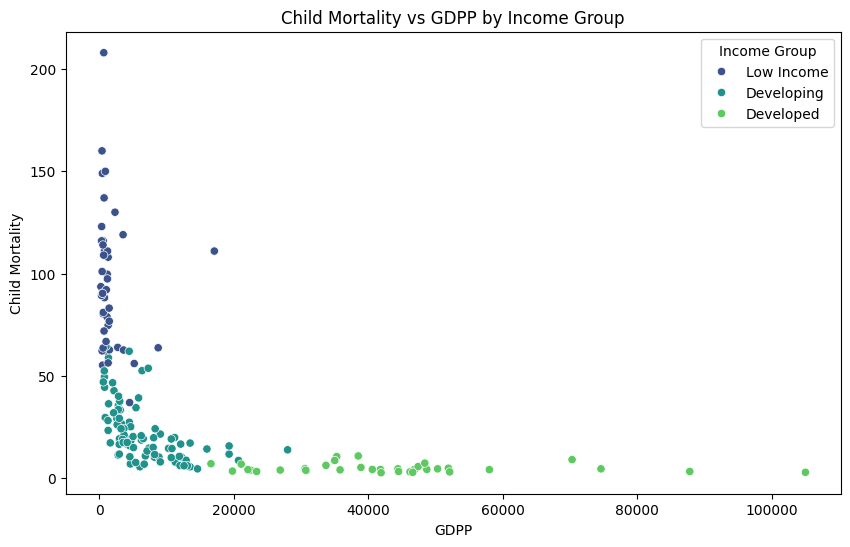

In [80]:
# Visualisation of clusters: child mortality vs gdpp
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_df, x='gdpp', y='child_mort', hue='income_group', palette='viridis')
plt.xlabel('GDPP')
plt.ylabel('Child Mortality')
plt.title('Child Mortality vs GDPP by Income Group')
plt.legend(title='Income Group')
plt.show()

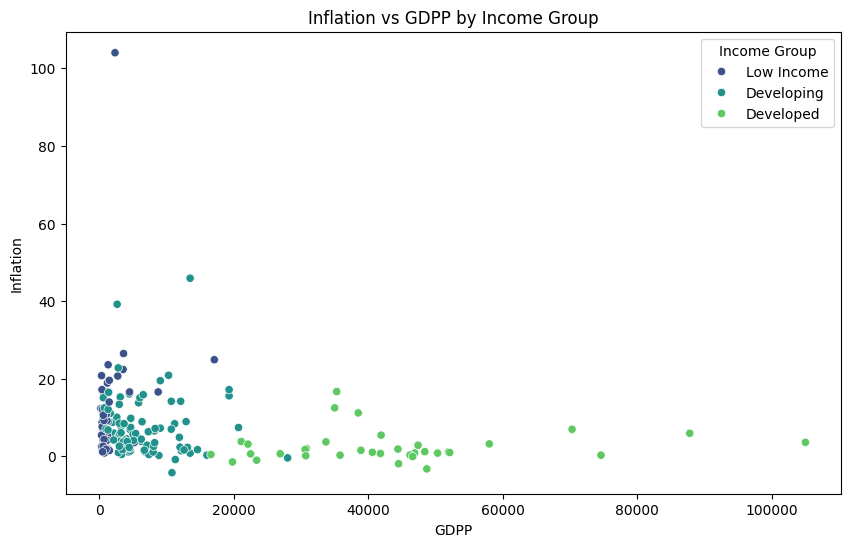

In [81]:
# Visualisation of clusters: inflation vs gdpp
plt.figure(figsize=(10, 6))
sns.scatterplot(data=country_df, x='gdpp', y='inflation', hue='income_group', palette='viridis')
plt.xlabel('GDPP')
plt.ylabel('Inflation')
plt.title('Inflation vs GDPP by Income Group')
plt.legend(title='Income Group')
plt.show()

## Conclusions

Label the groups of countries in the plots you created based on child mortality, GDPP and inflation. You may use [terms](https://en.wikipedia.org/wiki/Developing_country#Terms_used_to_classify_countries) such as: least developed, developing and developed, or low, low-middle, upper-middle and high income. Alternatively, simply rank them from highest to lowest. Justify the labels you assign to each group.


**Answer here:**

**Group 1 – Least Developed / Low Income Countries:**

Characteristics:

- High Child Mortality: these countries show relatively high rates of child mortality.

- Low GDPP: they have lower GDP per capita, which indicates less economic output per person.

- High Inflation: the inflation levels in this group are on the higher side, suggesting economic instability.

Justification:

The computed averages for this cluster—high child mortality, low GDPP, and high inflation, align with the profile typically observed in least developed or low-income nations. Such countries often struggle with inadequate healthcare systems and underperforming economies, justifying the label assigned to this group.

**Group 2 – Developing / Middle Income Countries:**

Characteristics:

- Moderate Child Mortality: these countries have child mortality rates that are neither very high nor very low.

- Moderate GDPP: their GDP per capita values are in the middle range, indicating transitional economies that are neither the poorest nor the richest.

- Moderate Inflation: inflation rates here are also moderate, pointing to economies in a state of transition.

Justification:

The average values for this cluster suggest a transitional phase where countries are still developing. With moderate figures across key indicators, this group is indicative of developing or middle-income countries that are improving their economic and healthcare infrastructures.

**Group 3 – Developed / High Income Countries:**

Characteristics:

- Low Child Mortality: countries in this cluster show very low child mortality rates, indicative of advanced healthcare systems.

- High GDPP: reflecting strong economic performance and higher average incomes.

- Low Inflation: these countries maintain lower inflation levels, which contributes to economic stability.

Justification:

The combination of low child mortality, high GDPP, and stable inflation rates strongly corresponds to developed or high-income nations. These indicators reflect well-established infrastructures, effective governance, and overall economic stability, which is why this cluster has been labeled as representing developed countries.